In [1]:
import os
import sys
sys.path.append('../')

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches  

from models.interaction_network import InteractionNetwork
from models.graph import Graph, save_graphs, load_graph
from models.dataset import Dataset

In [2]:
#plt.rc('font', family='dejavuserif', serif='Times')
#plt.rc('text', usetex=True)
#plt.rc('xtick', labelsize=12)
#plt.rc('ytick', labelsize=12)
#plt.rc('axes', labelsize=12)
#colors = ['#377eb8', '#ff7f00', '#4daf4a',
#          '#f781bf', '#a65628', '#984ea3',
#          '#999999', '#e41a1c', '#dede00']
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

In [ ]:
# ELU 3/2

epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
scan = {'$R_1: 8, R_2: 8, O: 8$': {'loss': [0.0266, 0.0233, 0.0191, 0.0168, 0.0158, 0.0147, 0.0143, 0.0140, 0.0136, 0.0136, 0.0128, 0.0126, 0.0121, 0.0121, 0.0119, 0.0120, 0.0117, 0.0117, 0.0117, 0.0116, 0.0115, 0.0115],
                                   'acc':  [0.9878, 0.9889, 0.9901, 0.9903, 0.9922, 0.9929, 0.9931, 0.9933, 0.9935, 0.9934, 0.9940, 0.9942, 0.9943, 0.9944, 0.9945, 0.9944, 0.9946, 0.9946, 0.9946, 0.9946, 0.9947, 0.9946],
                                   'time': [271,    269,    274,    270,    266,    267,    271,    270,    270,    273,    270,    269,    280,    278,    289,    292,    289,    291,    295,    294,    289,    281]},
        '$R_1: 16, R_2: 8, O: 8$': {'loss': [0.0254, 0.0182, 0.0160, 0.0148, 0.0142, 0.0133, 0.0149, 0.0133, 0.0129, 0.0128, 0.0122, 0.0121, 0.0117, 0.0114, 0.0114, 0.0112, 0.0113, 0.0114, 0.0112, 0.0112, 0.0110, 0.0110],
                                    'acc':  [0.9876, 0.9909, 0.9922, 0.9928, 0.9932, 0.9936, 0.9930, 0.9936, 0.9939, 0.9939, 0.9942, 0.9943, 0.9944, 0.9946, 0.9947, 0.9948, 0.9947, 0.9947, 0.9948, 0.9948, 0.9949, 0.9949],
                                    'time': [260,    267,    263,    263,    261,    266,    263,    264,    261,    263,    261,    262,    269,    270,    268,    267,    273,    272,    271,    266,    266,    260]},
        '$R_1: 16, R_2: 16, O: 16$': {'loss': [0.0233, 0.0162, 0.0146, 0.0136, 0.0134, 0.0127, 0.0130, 0.0128, 0.0122, 0.0126, 0.0121, 0.0117, 0.0112, 0.0110, 0.0114, 0.0109, 0.0108, 0.0107, 0.0108, 0.0107, 0.0106, 0.0107],
                                      'acc':  [0.9885, 0.9921, 0.9929, 0.9934, 0.9936, 0.9940, 0.9938, 0.9939, 0.9943, 0.9940, 0.9943, 0.9946, 0.9948, 0.9949, 0.9948, 0.9950, 0.9950, 0.9950, 0.9950, 0.9951, 0.9951, 0.9951],
                                      'time': [274,    269,    267,    269,    268,    271,    276,    271,    275,    270,    272,    271,    277,    277,    274,    276,    276,    279,    273,    276,    271,    276]},
        '$R_1: 25, R_2: 25, O: 25$': {'loss': [0.0232, 0.0155, 0.0153, 0.0138, 0.0129, 0.0126, 0.0124, 0.0125, 0.0130, 0.0121, 0.0120, 0.0118, 0.0110, 0.0111, 0.0108, 0.0106, 0.0108, 0.0106, 0.0107, 0.0105, 0.0105, 0.0104],
                                      'acc':  [0.9886, 0.9923, 0.9926, 0.9933, 0.9938, 0.9940, 0.9941, 0.9942, 0.9938, 0.9943, 0.9943, 0.9946, 0.9949, 0.9949, 0.9950, 0.9951, 0.9951, 0.9951, 0.9950, 0.9951, 0.9951, 0.9952],
                                      'time': [275,    275,    277,    274,    274,    273,    273,    273,    271,    273,    273,    272,    278,    283,    278,    278,    285,    282,    274,    277,    276,    278]},
        '$R_1: 40, R_2: 25, O: 25$':  {'loss': [0.0481, 0.0200, 0.0140, 0.0135, 0.0127, 0.0127, 0.0121, 0.0119, 0.0123, 0.0116, 0.0115, 0.0111, 0.0110, 0.0118, 0.0109, 0.0107, 0.0107, 0.0106, 0.0107, 0.0105, 0.0107, 0.0104],
                                       'acc':  [0.9815, 0.9898, 0.9930, 0.9934, 0.9939, 0.9939, 0.9942, 0.9944, 0.9942, 0.9946, 0.9946, 0.9948, 0.9949, 0.9946, 0.9949, 0.9950, 0.9951, 0.9951, 0.9951, 0.9952, 0.9951, 0.9952],
                                       'time': [267,    266,    267,    269,    270,    268,    266,    265,    268,    266,    269,    267,    274,    272,    270,    275,    271,    269,    270,    272,    271,    272]},
        '$R_1: 40, R_2: 40, O: 40$': {'loss':  [0.0246, 0.0156, 0.0147, 0.0135, 0.0123, 0.0123, 0.0121, 0.0121, 0.0117, 0.0123, 0.0115, 0.0113, 0.0110, 0.0110, 0.0108, 0.0109, None, None, None, None, None, None], #EPOCH 40
                                      'acc':   [0.9884, 0.9923, 0.9929, 0.9936, 0.9942, 0.9943, 0.9944, 0.9945, 0.9945, 0.9943, 0.9948, 0.9948, 0.9950, 0.9949, 0.9951, 0.9950, None, None, None, None, None, None],
                                      'time':  [550,    531,    537,    532,    531,    548,    546,    543,    534,    532,    549,    552,    554,    554,    537,    564,    None, None, None, None, None, None]},
        '$R_1: 64, R_2: 40, O: 40$': {'loss': [0.0224, 0.0145, 0.0130, 0.0128, 0.0122, 0.0123, 0.0118, 0.0117, 0.0118, 0.0122, 0.0118, 0.0113, 0.0111, 0.0109, 0.0108, 0.0109, 0.0106, 0.0106, 0.0105, 0.0103, 0.0103, 0.0103],
                                      'acc':  [0.9900, 0.9929, 0.9937, 0.9941, 0.9943, 0.9942, 0.9944, 0.9945, 0.9944, 0.9943, 0.9944, 0.9948, 0.9949, 0.9950, 0.995,  0.9949, 0.9951, 0.9951, 0.9951, 0.9952, 0.9953, 0.9952],
                                      'time': [274,    272,    272,    271,    274,    271,    273,    273,    272,    273,    272,    276,    279,    279,    280,    278,    281,    278,    278,    279,    285,    283]},
        '$R_1: 64, R_2: 64, O: 64$': {'loss': [0.0478, 0.0170, 0.0136, 0.0124, 0.0126, 0.0121, 0.0117, 0.0126, 0.0117, 0.0115, 0.0112, 0.0108, 0.0108, 0.0109, 0.0106, 0.0102, None, None, None, None, None, None], #EPOCH 25
                                      'acc':  [0.9816, 0.9913, 0.9935, 0.9940, 0.9942, 0.9943, 0.9945, 0.9942, 0.9945, 0.9946, 0.9948, 0.9950, 0.9951, 0.9949, 0.9951, 0.9953, None, None, None, None, None, None],
                                      'time': [519,    535,    532,    529,    535,    512,    526,    519,    546,    522,    526,    524,    534,    539,    523,    525,    None, None, None, None, None, None]},
        '$R_1: 120, R_2: 80, O: 80$': {'loss': [0.0180, 0.0135, 0.0132, 0.0132, 0.0129, 0.0126, 0.0115, 0.0121, 0.0114, 0.0115, 0.0109, 0.0108, 0.0107, 0.0103, 0.0103, 0.0102, 0.0102, 0.0063, 0.0056, 0.0058, 0.0054, 0.0051],
                                       'acc':  [0.9913, 0.9934, 0.9937, 0.9936, 0.9940, 0.9941, 0.9946, 0.9941, 0.9947, 0.9946, 0.9949, 0.9950, 0.9951, 0.9952, 0.9952, 0.9952, 0.9953, 0.9972, 0.9974, 0.9975, 0.9976, 0.9977],
                                       'time': [275,    273,    273,    275,    276,    273,    274,    271,    272,    273,    274,    272,    273,    275,    273,    272,    275,    280,    270,    271,    275,    276]},
        '$R_1: 120, R_2: 120, O: 120$': {'loss': [0.0180, 0.0146, 0.0124, 0.0135, 0.0132, 0.0118, 0.0121, 0.0117, 0.0116, 0.0117, 0.0112, 0.0115, 0.0109, 0.0106, 0.0091, 0.0063, 0.0058, 0.0056, 0.0053, 0.0053, 0.0051, 0.0051],
                                         'acc':  [0.9910, 0.9931, 0.9941, 0.9934, 0.9938, 0.9945, 0.9943, 0.9946, 0.9945, 0.9946, 0.9948, 0.9946, 0.9949, 0.9951, 0.9958, 0.9972, 0.9973, 0.9975, 0.9976, 0.9977, 0.9976, 0.9977],
                                         'time': [272,    267,    268,    268,    269,    268,    271,    269,    269,    270,    269,    269,    269,    272,    277,    277,    272,    274,    276,    272,    276,    270]},
        '$R_1: 160, R_2: 120, O: 120$': {'loss': [0.0159, 0.0147, 0.0127, 0.0125, 0.0128, 0.0127, 0.0121, 0.0117, 0.0121, 0.0121, 0.0116, 0.0109, 0.0109, 0.0103, 0.0108, 0.0103, 0.0102, 0.0101, 0.0102, 0.0089, 0.0061, 0.0055],
                                         'acc':  [0.9919, 0.9927, 0.9940, 0.9942, 0.9939, 0.9941, 0.9944, 0.9946, 0.9943, 0.9945, 0.9947, 0.9950, 0.9950, 0.9952, 0.9950, 0.9953, 0.9953, 0.9953, 0.9953, 0.9959, 0.9972, 0.9975],
                                         'time': [272,    272,    271,    274,    270,    275,    268,    275,    271,    271,    273,    271,    275,    279,    277,    281,    287,    286,    283,    285,    283,    280]}
       }

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), dpi=200, sharex=True)
for i, key in enumerate(scan.keys()):
    axs[0].plot(epoch, scan[key]['loss'], color=colors[i%9], label=key, marker='.', lw=1)
    axs[1].plot(epoch, scan[key]['acc'], color=colors[i%9], label=key, marker='.', lw=1)
    axs[2].plot(epoch, scan[key]['time'], color=colors[i%9], label=key, marker='.', lw=1)

axs[0].set_ylabel("BCE Loss")
axs[1].set_ylabel("Accuracy")
axs[2].set_ylabel("Epoch Time [s]")
axs[2].set_xlabel("Epoch")
axs[1].legend(bbox_to_anchor=(1.5, 1.1))
plt.tight_layout()
plt.show()

In [ ]:
# ElU 3/2
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
scan = {'$p_T > 2$ GeV': 
        {'$R_1: 80,\ R_2: 80,\ O:80$': {'loss': [0.0293, 0.0387, 0.0237, 0.0225, 0.0241, 0.0219, 0.0207, 0.0189, 0.0228, 0.0118, 0.0175, 0.0179, 0.0166, 0.0140, 0.0105, 0.0099, 0.0097, 0.0095, 0.0100],
                                        'acc':  [0.9871, 0.9855, 0.9904, 0.9907, 0.9903, 0.9912, 0.9917, 0.9925, 0.9907, 0.9924, 0.9932, 0.9930, 0.9935, 0.9946, 0.9959, 0.9961, 0.9964, 0.9965, 0.9965]},
         '$R_1: 100,\ R_2: 100,\ O: 100$': {'loss': [0.0424, 0.0294, 0.0250, 0.0237, 0.0224, 0.0206, 0.0211, 0.0215, 0.0198, 0.0186, 0.0184, 0.0183, 0.0110, 0.0101, 0.0092, 0.0090, 0.0091, 0.0089, 0.0091],
                                            'acc':  [0.9844, 0.9883, 0.9900, 0.9904, 0.9910, 0.9916, 0.9912, 0.9920, 0.9925, 0.9920, 0.9926, 0.9925, 0.9957, 0.9960, 0.9964, 0.9965, 0.9964, 0.9965, 0.9966]},
         '$R_1: 120,\ R_2: 120,\ O: 120$': {'loss': [0.0316, 0.0236, 0.0223, 0.0241, 0.0215, 0.0218, 0.0214, 0.0200, 0.0184, 0.0198, 0.0179, 0.0178, 0.0161, 0.0110, 0.0098, 0.0096, 0.0090, 0.0088, 0.0088],
                                            'acc':  [0.9868, 0.9903, 0.9909, 0.9902, 0.9914, 0.9910, 0.9912, 0.9917, 0.9925, 0.9921, 0.9925, 0.9926, 0.9934, 0.9956, 0.9962, 0.9964, 0.9965, 0.9966, 0.9966]},
        },
        '$p_T > 1.5$ GeV': 
        {'$R_1: 100,\ R_2: 100,\ O: 100$': {'loss': [0.0196, 0.0163, 0.0175, 0.0225, 0.0151, 0.0140, 0.0145, 0.0145, 0.0133, 0.0140, 0.0130, 0.0120, 0.0121, 0.0114, 0.0114, 0.0110, 0.0110, 0.0107, 0.0107],
                                            'acc':  [0.9915, 0.9929, 0.9923, 0.9908, 0.9936, 0.9943, 0.9939, 0.9942, 0.9946, 0.9941, 0.9945, 0.9950, 0.9949, 0.9953, 0.9954, 0.9955, 0.9955, 0.9956, 0.9957]},
         '$R_1: 120,\ R_2: 120,\ O: 120$': {'loss': [0.0220, 0.0216, 0.0155, 0.0151, 0.0156, 0.0164, 0.0135, 0.0129, 0.0167, 0.0148, 0.0125, 0.0121, 0.0085, 0.0070, 0.0063, 0.0060, 0.0058, 0.0056, 0.0063],
                                            'acc':  [0.9905, 0.9897, 0.9934, 0.9936, 0.9931, 0.9930, 0.9943, 0.9946, 0.9939, 0.9937, 0.9948, 0.9951, 0.9966, 0.9973, 0.9975, 0.9976, 0.9977, 0.9977, 0.9976]},
        },
        '$p_T > 1$ GeV': 
        {'$R_1: 100,\ R_2: 100,\ O: 100$': {'loss': [0.0168, 0.0139, 0.0136, 0.0126, 0.0131, 0.0122, 0.0119, 0.0121, 0.0119, 0.0119, 0.0111, 0.0108,   0.0104,   0.0073,   0.0058,   None,   None,   None,   None],
                                            'acc':  [0.9920, 0.9933, 0.9935, 0.9940, 0.9938, 0.9943, 0.9944, 0.9942, 0.9946, 0.9947, 0.9949, 0.9950,   0.9952,   0.9967,   0.9974,   None,   None,   None,   None]},
         '$R_1: 120,\ R_2: 120,\ O: 120$': {'loss': [0.0173, 0.0138, 0.0146, 0.0124, 0.0121, 0.0117, 0.0118, 0.0114, 0.0121, 0.0118, 0.0114, 0.0106, 0.0104, 0.0102,   0.0058,   0.0052,   0.0051,   None,   None],
                                            'acc':  [0.9915, 0.9933, 0.9938, 0.9942, 0.9945, 0.9945, 0.9945, 0.9948, 0.9943, 0.9945, 0.9947, 0.9951, 0.9952, 0.9953,   0.9974,   0.9977,   0.9977,   None,   None]},
        }
       }

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,6), dpi=200, sharex=True)
counter = 0
for pt in scan.keys():
    for i, key in enumerate(scan[pt].keys()):
        axs[0].plot(epoch, scan[pt][key]['loss'], color=colors[counter], label=pt+';  '+key, marker='.', lw=1)
        axs[1].plot(epoch, scan[pt][key]['acc'], color=colors[counter], label=pt+';  '+key, marker='.', lw=1)
        counter+=1

axs[0].set_ylabel("BCE Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [3]:
# ReLU w/ 2/2 layer split FOR PAPER

epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]
scan = {'$p_T > 2$ GeV': 
        {'$R_1: 20,\ R_2: 20,\ O: 20$': {'loss':    [0.0344, 0.0288, 0.0347, 0.0253, 0.0249, 0.0229, 0.0221, 0.0215, 0.0216, 0.0216, 0.0198, 0.0187, 0.0184, 0.0186, 0.0175, 0.0178, 0.0176, 0.0175], # does not converge further at epoch 100
                                         'acc':     [0.9857, 0.9871, 0.9870, 0.9891, 0.9900, 0.9908, 0.9908, 0.9907, 0.9911, 0.9908, 0.9919, 0.9922, 0.9924, 0.9924, 0.9928, 0.9927, 0.9928, 0.9928]},
         '$R_1: 40,\ R_2: 40,\ O: 40$': {'loss':    [0.0319, 0.0290, 0.0253, 0.0236, 0.0212, 0.0208, 0.0210, 0.0179, 0.0156, 0.0162, 0.0132, 0.0123, 0.0115, 0.0122, 0.0111, 0.0106, 0.0099, 0.0099],
                                         'acc':     [0.9865, 0.9875, 0.9893, 0.9901, 0.9913, 0.9912, 0.9910, 0.9929, 0.9937, 0.9937, 0.9947, 0.9952, 0.9954, 0.9952, 0.9957, 0.9958, 0.9961, 0.9961]}, # does not converge further 
         '$R_1: 60,\ R_2: 60,\ O: 60$': {'loss':    [0.0298, 0.0271, 0.0265, 0.0242, 0.0237, 0.0204, 0.0247, 0.0211, 0.0201, 0.0172, 0.0135, 0.0122, 0.0112, 0.0108, 0.0105, 0.0103, 0.0101, 0.0102],
                                         'acc':     [0.9869, 0.9883, 0.9893, 0.9902, 0.9904, 0.9916, 0.9897, 0.9916, 0.9919, 0.9929, 0.9946, 0.9951, 0.9954, 0.9956, 0.9957, 0.9959, 0.9959, 0.9961]}, # converges to 0.9964
        },
        '$p_T > 1.5$ GeV': 
        {'$R_1: 40,\ R_2: 40,\ O: 40$': {'loss':    [0.0241, 0.0189, 0.0173, 0.0173, 0.0153, 0.0158, 0.0139, 0.0141, 0.0150, 0.0139, 0.0135, 0.0127, 0.0101, 0.0091, 0.0080, 0.0077, 0.0074, 0.0073],
                                         'acc':     [0.9892, 0.9912, 0.9925, 0.9924, 0.9936, 0.9933, 0.9941, 0.9940, 0.9936, 0.9942, 0.9945, 0.9946, 0.9958, 0.9962, 0.9967, 0.9969, 0.9970, 0.9969]}, # converges to 0.9974
         '$R_1: 60,\ R_2: 60,\ O: 60$': {'loss':    [0.0210, 0.0185, 0.0167, 0.0167, 0.0140, 0.0125, 0.0117, 0.0114, 0.0105, 0.0103, 0.0095, 0.0078, 0.0076, 0.0076, 0.0071, 0.0067, 0.0066, 0.0067],
                                         'acc':     [0.9900, 0.9917, 0.9925, 0.9928, 0.9940, 0.9947, 0.9950, 0.9951, 0.9957, 0.9957, 0.9961, 0.9968, 0.9969, 0.9969, 0.9971, 0.9973, 0.9973, 0.9973]}, #6030585
        },
        '$p_T^{min}=1$ GeV': 
        {'$10$ h.u.': {'loss':  [0.0337, 0.0233, 0.0193, 0.0180, 0.0174, 0.0174, 0.0154, 0.0149, 0.0140, 0.0134, 0.0125, 0.0119, 0.0114, 0.0107, 0.0110, 0.0100, 0.0121],
                       'acc':   [0.9833, 0.9891, 0.9899, 0.9907, 0.9909, 0.9912, 0.9921, 0.9925, 0.9931, 0.9934, 0.9940, 0.9944, 0.9946, 0.9949, 0.9949, 0.9953, 0.9950]},
         '$20$ h.u.': {'loss':  [0.0194, 0.0174, 0.0155, 0.0141, 0.0140, 0.0134, 0.0135, 0.0129, 0.0131, 0.0127, 0.0122, 0.0122, 0.0118, 0.0118, 0.0115, 0.0114, 0.0114],
                       'acc':   [0.9900, 0.9912, 0.9922, 0.9929, 0.9932, 0.9935, 0.9935, 0.9937, 0.9937, 0.9938, 0.9942, 0.9942, 0.9944, 0.9945, 0.9945, 0.9947, 0.9947]},
         '$30$ h.u.': {'loss':  [0.0197, 0.0165, 0.0142, 0.0136, 0.0125, 0.0112, 0.0105, 0.0097, 0.0094, 0.0088, 0.0076, 0.0071, 0.0068, 0.0066, 0.0063, 0.0060, 0.0059],
                       'acc':   [0.9894, 0.9916, 0.9929, 0.9935, 0.9940, 0.9946, 0.9950, 0.9954, 0.9956, 0.9960, 0.9966, 0.9968, 0.9969, 0.9970, 0.9971, 0.9973, 0.9973]},
         '$40$ h.u.': {'loss':  [0.0185, 0.0162, 0.0146, 0.0133, 0.0120, 0.0110, 0.0104, 0.0099, 0.0095, 0.0085, 0.0071, 0.0066, 0.0064, 0.0061, 0.0060, 0.0060, 0.0058],
                       'acc':   [0.9899, 0.9921, 0.9926, 0.9935, 0.9943, 0.9948, 0.9951, 0.9955, 0.9956, 0.9961, 0.9968, 0.9970, 0.9971, 0.9972, 0.9973, 0.9972, 0.9974]},
         #'60$ h.u.': {'loss':  [0.0172, 0.0139, 0.0123, 0.0108, 0.0101, 0.0096, 0.0091, 0.0082, 0.0082, 0.0075, 0.0067, 0.0065, 0.0064, 0.0064, 0.0060, None,   None],
         #              'acc':   [0.9907, 0.9931, 0.9940, 0.9950, 0.9952, 0.9955, 0.9958, 0.9963, 0.9964, 0.9964, 0.9970, 0.9970, 0.9971, 0.9972, 0.9973, None,   None]},
         '$80$ h.u.': {'loss':  [0.0165, 0.0147, 0.0132, 0.0115, 0.0104, 0.0097, 0.0100, 0.0094, 0.0094, 0.0091, 0.0067, 0.0069, 0.0060, 0.0059, 0.0057, 0.0055, 0.0055],
                       'acc':   [0.9913, 0.9925, 0.9935, 0.9945, 0.9951, 0.9954, 0.9954, 0.9956, 0.9955, 0.9957, 0.9969, 0.9968, 0.9973, 0.9974, 0.9974, 0.9975, 0.9975]},
         #'$100$ h.u.': {'loss': [0.0170, 0.0140, 0.0125, 0.0106, 0.0102, 0.0097, 0.0084, 0.0077, 0.0074, 0.0070, 0.0065, 0.0065, 0.0063, 0.0059, 0.0056, 0.0058, 0.0057],
         #               'acc':  [0.9916, 0.9931, 0.9939, 0.9950, 0.9952, 0.9955, 0.9960, 0.9965, 0.9965, 0.9967, 0.9970, 0.9970, 0.9971, 0.9973, 0.9974, 0.9974, 0.9975]},
         '$120$ h.u.': {'loss': [0.0165, 0.0143, 0.0126, 0.0105, 0.0101, 0.0090, 0.0081, 0.0073, 0.0075, 0.0074, 0.0063, 0.0063, 0.0059, 0.0057, 0.0057, 0.0054, 0.0054],
                        'acc':  [0.9914, 0.9931, 0.9940, 0.9950, 0.9955, 0.9960, 0.9962, 0.9967, 0.9967, 0.9966, 0.9971, 0.9971, 0.9973, 0.9974, 0.9974, 0.9976, 0.9975]},
        }
       }

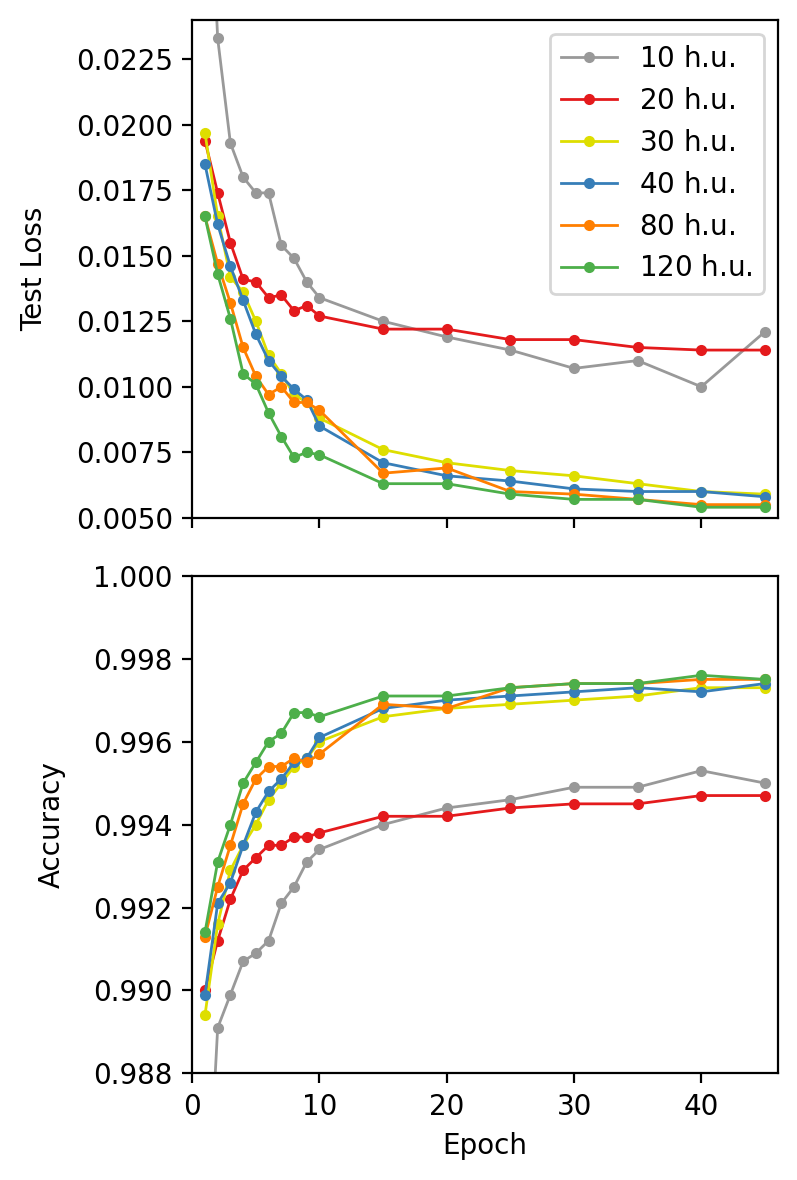

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,6), dpi=200, sharex=True)
for i, key in enumerate(scan['$p_T^{min}=1$ GeV'].keys()):
    axs[0].plot(epoch, scan['$p_T^{min}=1$ GeV'][key]['loss'], color=colors[(i+6)%9], label=key, marker='.', lw=1)
    axs[1].plot(epoch, scan['$p_T^{min}=1$ GeV'][key]['acc'], color=colors[(i+6)%9], label=key, marker='.', lw=1)

axs[0].set_ylabel("Test Loss", labelpad=10)
axs[1].set_ylabel("Accuracy", labelpad=10)
axs[1].set_xlabel("Epoch")
axs[1].set_xlim([0,46])
axs[0].set_xlim([0,46])
#axs[1].legend(bbox_to_anchor=(1.25, 1.35))
axs[0].legend(loc='upper right')
axs[0].set_ylim([0.005,0.024])
axs[1].set_ylim([0.988,1])
plt.tight_layout()
plt.savefig('hyperparam_scan_1GeV.pdf', format='PDF', bbox_inches='tight')
plt.show()

In [7]:
def draw_graph_rz(X, Ri, Ro, y, out,                   
                  cut=0.5, savefig=False, filename='out.png'):
    
    X = X.transpose()
    feats_o = Ro @ X
    feats_i = Ri @ X
    
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(X[:,2], X[:,0], c='silver', lw=0, marker='s', s=8)
    
    true_pos = ((out>cut) & (y>0.5))
    true_neg = ((out<cut) & (y<0.5))
    false_pos = ((out>cut) & (y<0.5))
    false_neg = ((out<cut) & (y>0.5))
    wrong = (((out<cut) & (y>0.5)) | ((out>cut) & (y<0.5)))
    
    print('True Pos: {}/{}={}', np.sum(true_pos), len(true_pos), np.sum(true_pos)/len(true_pos))
    print('True Neg: {}/{}={}', np.sum(true_neg), len(true_neg), np.sum(true_neg)/len(true_neg))
    print('False Pos: {}/{}={}', np.sum(false_pos), len(false_pos), np.sum(false_pos)/len(false_pos))
    print('False Neg: {}/{}={}', np.sum(false_neg), len(false_neg), np.sum(false_neg)/len(false_neg))
    print('Wrong: {}/{}={}', np.sum(wrong), len(wrong), np.sum(wrong)/len(wrong))
    print('Right: {}/{}={}', np.sum((true_pos|true_neg)), len(true_pos), np.sum((true_pos|true_neg))/len(true_pos))
    
    ax.plot((feats_o[true_pos][:,2], feats_i[true_pos][:,2]),
            (feats_o[true_pos][:,0], feats_i[true_pos][:,0]),
            'go-', lw=0.1, ms=0.0, alpha=0.5)
    ax.plot((feats_o[true_neg][:,2], feats_i[true_neg][:,2]),
            (feats_o[true_neg][:,0], feats_i[true_neg][:,0]),
            'ko-', lw=0.02, ms=0.0, alpha=0.05)
    #ax.plot((feats_o[wrong][:,2], feats_i[wrong][:,2]),
    #        (feats_o[wrong][:,0], feats_i[wrong][:,0]),
    #        'ro-', lw=0.1, ms=0.0, alpha=0.8)
    ax.plot((feats_o[false_pos][:,2], feats_i[false_pos][:,2]),
            (feats_o[false_pos][:,0], feats_i[false_pos][:,0]),
            'ro-', lw=0.3, ms=0.0, alpha=0.8, zorder=10)
    ax.plot((feats_o[false_neg][:,2], feats_i[false_neg][:,2]),
            (feats_o[false_neg][:,0], feats_i[false_neg][:,0]),
            'yo-', lw=0.3, ms=0.0, alpha=0.8, zorder=10)

    green_patch = mpatches.Patch(color='green', label='True Positive')
    black_patch = mpatches.Patch(color='black', label='True Negative')
    red_patch = mpatches.Patch(color='red', label='False Positive')
    yellow_patch = mpatches.Patch(color='yellow', label='False Negative')
    ax.legend(handles=[green_patch, black_patch, red_patch, yellow_patch], loc='lower right')#bbox_to_anchor=[0.67, -0.2])
    ax.set_ylabel("r [m]")
    ax.set_xlabel("z [m]")
    ax.set_xlim([-1.6, 1.6])
    ax.set_xticks([-1.5, 1.5])
    ax.set_yticks([0.02, 0.2])
    ax.set_ylim([0, 0.2])
    if (savefig): plt.savefig(filename, format='PDF', bbox_inches='tight')
    plt.show()

In [8]:
construction, pt = 'heptrkx_plus', '1'
graph_indir = "../../hitgraphs_2/{}_{}/".format(construction, pt)
graph_files = np.array(os.listdir(graph_indir))
train_2_mask = [(int(graph_file.split("00000")[1].split("_")[0]) > 2820)
                    for graph_file in graph_files]
graph_files = graph_files[train_2_mask]
n_graphs = len(graph_files)

IDs = np.arange(n_graphs)
np.random.shuffle(IDs)
partition = {'train': graph_files[IDs[:1000]],  
             'test':  graph_files[IDs[1000:1400]],
             'val': graph_files[IDs[1400:1500]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
test_set = Dataset(graph_indir, partition['test']) 
test_loader = torch.utils.data.DataLoader(test_set, **params)

0.0059884535148739815
True Pos: {}/{}={} 4037 29661 0.1361046492026567
True Neg: {}/{}={} 25567 29661 0.8619736354135059
False Pos: {}/{}={} 31 29661 0.0010451434543676881
False Neg: {}/{}={} 26 29661 0.000876571929469674
Wrong: {}/{}={} 57 29661 0.0019217153838373621
Right: {}/{}={} 29604 29661 0.9980782846161627


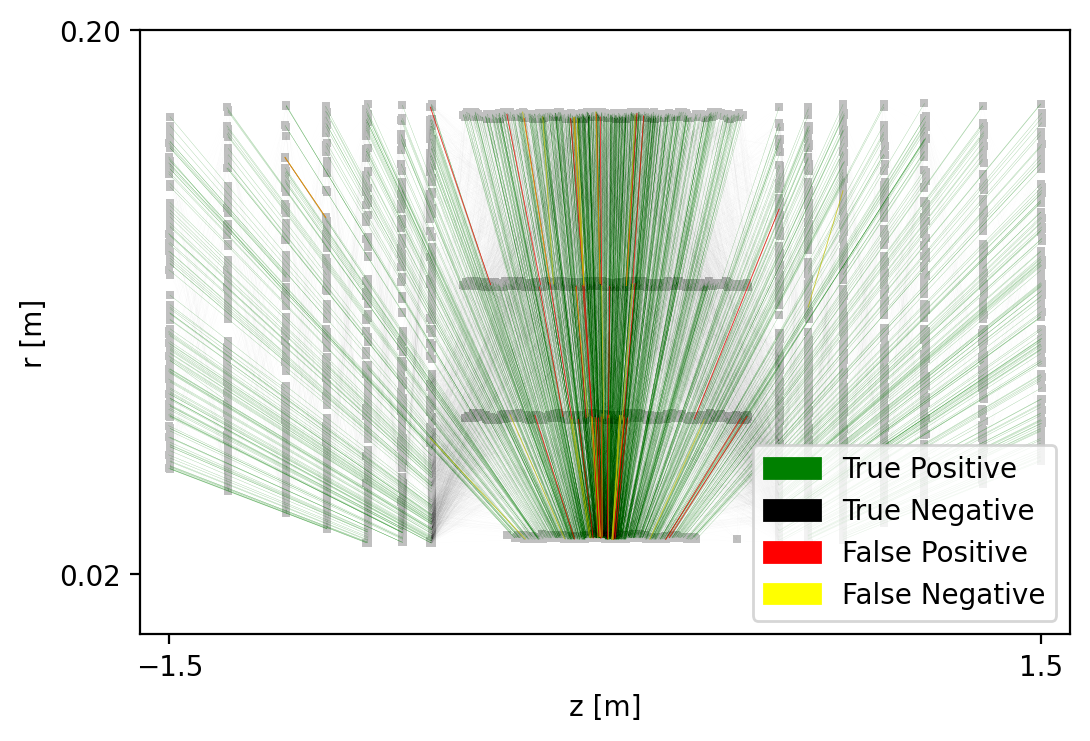

In [9]:
criterion = nn.BCELoss()
interaction_network = InteractionNetwork(3, 4, 4)
losses, epochs = [], []
model='../trained_models/train1_40hu_heptrkx_plus_epoch48_1GeV.pt'
interaction_network.load_state_dict(torch.load(model))
interaction_network.eval()
for batch_idx, (graph, target) in enumerate(test_loader):
    X, Ra = graph['X'], graph['Ra']
    Ri, Ro = graph['Ri'], graph['Ro']
    target = target['y']
    predicted = interaction_network(X, Ra.float(), Ri.float(), Ro.float())
    predicted = predicted.squeeze(2)
    loss = (criterion(predicted, target))
    losses.append(loss.item())
    print(loss.item())
    draw_graph_rz(X.detach().numpy()[0], Ri.detach().numpy()[0], 
                  Ro.detach().numpy()[0], target.detach().numpy()[0], 
                  predicted.detach().numpy()[0], cut=0.5, savefig=True,
                  filename='train_classified_edges.pdf')
    break


In [ ]:
# HEPTRKX+
heptrkx_plus = {
        '$p_T^{min} = 2$ GeV': {'train_loss': [0.0581, 0.0300, 0.0269, 0.0245, 0.0225, 0.0211, 0.0200, 0.0191, 0.0176, 0.0158, 0.0148, 0.0142, 0.0141, 0.0137, 0.0135, 0.0131, 0.0123, 0.0128, 0.0124, 0.0124, 0.0119, 0.0117, 0.0115, 0.0115, 0.0113, 0.0110, 0.0110, 0.0109, 0.0108, 0.0106, 0.0104, 0.0102, 0.0103, 0.0103, 0.0101, 0.0099, 0.0099, 0.0099, 0.0098, 0.0098, 0.0096, 0.0096, 0.0095, 0.0095, 0.0094, 0.0094, 0.0093, 0.0092, 0.0093, 0.0092, 0.0091, 0.0090, 0.0091, 0.0090, 0.0090, 0.0089, 0.0088, 0.0088, 0.0088, 0.0088],
                                'test_loss':  [0.0317, 0.0286, 0.0272, 0.0226, 0.0231, 0.0211, 0.0191, 0.0185, 0.0171, 0.0145, 0.0138, 0.0132, 0.0140, 0.0128, 0.0131, 0.0130, 0.0123, 0.0127, 0.0126, 0.0122, 0.0110, 0.0113, 0.0116, 0.0115, 0.0112, 0.0108, 0.0112, 0.0104, 0.0108, 0.0106, 0.0106, 0.0111, 0.0103, 0.0103, 0.0107, 0.0103, 0.0100, 0.0096, 0.0095, 0.0104, 0.0100, 0.0095, 0.0098, 0.0093, 0.0099, 0.0099, 0.0095, 0.0093, 0.0096, 0.0095, 0.0098, 0.0091, 0.0093, 0.0092, 0.0089, 0.0091, 0.0093, 0.0093, 0.0092, 0.0092],
                                'acc':  []
                               },
        '$p_T^{min} = 1.5$ GeV': {'train_loss': [0.0493, 0.0199, 0.0172, 0.0156, 0.0147, 0.0138, 0.0127, 0.0116, 0.0109, 0.0104, 0.0098, 0.0096, 0.0094, 0.0092, 0.0091, 0.0088, 0.0087, 0.0086, 0.0084, 0.0084, 0.0082, 0.0081, 0.0081, 0.0079, 0.0078, 0.0077, 0.0076, 0.0075, 0.0075, 0.0074, 0.0073, 0.0072, 0.0072, 0.0072, 0.0072, 0.0070, 0.0070, 0.0069, 0.0069, 0.0069, 0.0068, 0.0068, 0.0068, 0.0068, 0.0067, 0.0067, 0.0066, 0.0066, 0.0066, 0.0066, 0.0065, 0.0065, 0.0065, 0.0064, 0.0065, 0.0064, 0.0063, 0.0063, 0.0063, 0.0063],
                                  'test_loss':  [0.0219, 0.0182, 0.0166, 0.0158, 0.0148, 0.0134, 0.0121, 0.0110, 0.0110, 0.0103, 0.0100, 0.0098, 0.0098, 0.0095, 0.0094, 0.0093, 0.0091, 0.0087, 0.0083, 0.0082, 0.0084, 0.0080, 0.0082, 0.0079, 0.0078, 0.0081, 0.0077, 0.0078, 0.0077, 0.0075, 0.0072, 0.0073, 0.0077, 0.0073, 0.0072, 0.0074, 0.0072, 0.0075, 0.0074, 0.0070, 0.0076, 0.0070, 0.0072, 0.0070, 0.0071, 0.0072, 0.0068, 0.0069, 0.0069, 0.0068, 0.0066, 0.0066, 0.0066, 0.0069, 0.0068, 0.0066, 0.0068, 0.0067, 0.0065, 0.0066],
                                  'acc':  []
                                 },
        '$p_T^{min} = 1$ GeV': {'train_loss': [],
                                  'test_loss':  [0.0185, 0.0162, 0.0146, 0.0133, 0.0120, 0.0110, 0.0104, 0.0099, 0.0095, 0.0085, 0.0077, 0.0076, 0.0072, 0.0072, 0.0071, 0.0068, 0.0069, 0.0068, 0.0066, 0.0066, 0.0066, 0.0065, 0.0066, 0.0063, 0.0064, 0.0063, 0.0062, 0.0063, 0.0061, 0.0061, 0.0062, 0.0061, 0.0062, 0.0060, 0.0060, 0.0059, 0.0062, 0.0060, 0.0060, 0.0060, 0.0059, 0.0059, 0.0060, 0.0061, 0.0058, 0.0058, 0.0060, 0.0059, None, None, None, None, None, None, None, None, None, None, None, None],
                                  'acc':  []
                                 },
        #'$p_T^{min} > 0.75$ GeV': {'train_loss': [],
        #                           'test_loss':  [0.0159, 0.0131, 0.0117, 0.0110, 0.0115, 0.0095, 0.0096, 0.0086, 0.0085, 0.0086, 0.0083, 0.0085, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
        #                           'acc':  []
        #                          },
        '$p_T^{min} = 0.75$ GeV': {'train_loss': [],
                                   'test_loss':  [0.0168, 0.0153, 0.0150, 0.0144, 0.0137, 0.0129, 0.0128, 0.0122, 0.0107, 0.0102, 0.0098, 0.0095, 0.0091, 0.0089, 0.0088, 0.0083, 0.0081, 0.0082, 0.0077, 0.0077, 0.0076, 0.0075, 0.0076, 0.0073, 0.0075, 0.0073, 0.0072, 0.0073, 0.0074, 0.0070, 0.0072, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
                                   'acc':  []
                                  },
        '$p_T^{min} = 0.6$ GeV': {'train_loss': [],
                                  'test_loss':  [0.0156, 0.0146, 0.0139, 0.0112, 0.0096, 0.0090, 0.0085, 0.0082, 0.0084, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None],
                                  'acc':  []
                                  },
       }

heptrkx_classic = {
    
}

In [ ]:
counter = 0
fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
for pt in heptrkx_plus.keys():
    print(pt)
    #ax.plot(scan[pt]['train_loss'], color=colors[counter%9], label=pt, marker='.', lw=1)
    ax.plot(heptrkx_plus[pt]['test_loss'], color=colors[(counter+7)%9], label=pt, marker='.', lw=1)
    counter+=1

ax.set_ylabel("Test Loss", labelpad=10)
ax.set_xlabel("Epoch", labelpad=10)
ax.legend(loc='upper right', prop={'size': 12})
ax.set_xlim([0,40])
plt.savefig('test_losses.pdf', format='PDF', bbox_inches='tight')
plt.show()

In [ ]:
graph_pt = np.array([2, 1.5, 1, 0.75, 0.6])
results = {
    'Learned $p_T^{min}=2$ GeV': {
        'loss':     [0.0094, 0.0105, 0.0320, 0.0622, 0.0906],
        'loss_err': [0.0072, 0.0038, 0.0035, 0.0054, 0.0042],
        'acc':      [0.9965, 0.9963, 0.9906, 0.9802, 0.9768],
        'acc_err':  [0.0029, 0.0017, 0.0012, 0.0032, 0.0035],
        'tpr':      [0.9967, 0.9961, 0.9853, 0.9737, 0.9239], 
        'tpr_err':  [0.0038, 0.0024, 0.0042, 0.0110, 0.0236],
        'tnr':      [0.9963, 0.9963, 0.9913, 0.9806, 0.9796],
        'tnr_err':  [0.0029, 0.0017, 0.0013, 0.0042, 0.0046]
    },
    'Learned $p_T^{min}=1.5$ GeV': {
        'loss':     [0.0093, 0.0062, 0.0140, 0.0241, 0.0360],
        'loss_err': [0.0071, 0.0030, 0.0021, 0.0020, 0.0018],
        'acc':      [0.9962, 0.9975, 0.9934, 0.9868, 0.9799],
        'acc_err':  [0.0032, 0.0013, 0.0010, 0.0010, 0.0056],
        'tpr':      [0.9970, 0.9975, 0.9933, 0.9861, 0.9792], 
        'tpr_err':  [0.0034, 0.0017, 0.0019, 0.0028, 0.0056],
        'tnr':      [0.9956, 0.9975, 0.9934, 0.9868, 0.9979],
        'tnr_err':  [0.0035, 0.0013, 0.0010, 0.0010, 0.0021]
    },
    'Learned $p_T^{min}=1$ GeV': {
        'loss':     [0.0133, 0.0077, 0.0059, 0.0109, 0.0220],
        'loss_err': [0.0088, 0.0035, 0.0013, 0.0011, 0.0014],
        'acc':      [0.9945, 0.9968, 0.9973, 0.9931, 0.9842],
        'acc_err':  [0.0040, 0.0016, 0.0006, 0.0007, 0.0008],
        'tpr':      [0.9948, 0.9969, 0.9971, 0.9928, 0.9832], 
        'tpr_err':  [0.0051, 0.0025, 0.0013, 0.0016, 0.0025],
        'tnr':      [0.9941, 0.9967, 0.9973, 0.9932, 0.9842],
        'tnr_err':  [0.0042, 0.0016, 0.0006, 0.0007, 0.0008]
    },
    'Learned $p_T^{min}=0.75$ GeV': {
        'loss':     [0.0186, 0.0106, 0.0073, 0.0067, 0.0095],
        'loss_err': [0.0120, 0.0044, 0.0016, 0.0009, 0.0008],
        'acc':      [0.9918, 0.9952, 0.9965, 0.9960, 0.9932],
        'acc_err':  [0.0061, 0.0023, 0.0009, 0.0005, 0.0005],
        'tpr':      [0.9918, 0.9955, 0.9963, 0.9958, 0.9932], 
        'tpr_err':  [0.0075, 0.0030, 0.0017, 0.0011, 0.0013],
        'tnr':      [0.9916, 0.9951, 0.9965, 0.9960, 0.9935],
        'tnr_err':  [0.0061, 0.0024, 0.0009, 0.0005, 0.0005]
    },
    'Learned $p_T^{min}=0.6$ GeV': {
        'loss':     [0.0280, 0.0167, 0.0111, 0.0082, 0.0084],
        'loss_err': [0.0154, 0.0054, 0.0018, 0.0009, 0.0007],
        'acc':      [0.9881, 0.9926, 0.9947, 0.9953, 0.9943],
        'acc_err':  [0.0079, 0.0030, 0.0010, 0.0005, 0.0005],
        'tpr':      [0.9878, 0.9920, 0.9946, 0.9949, 0.9944], 
        'tpr_err':  [0.0108, 0.0046, 0.0023, 0.0015, 0.0015],
        'tnr':      [0.9880, 0.9927, 0.9947, 0.9953, 0.9943],
        'tnr_err':  [0.0077, 0.0028, 0.0009, 0.0005, 0.0004]
    },
    
}

In [ ]:
import matplotlib.colors as mcolors

losses = np.array([[0.0094, 0.0105, 0.0320, 0.0622],
                 [0.0093, 0.0062, 0.0140, 0.0241],
                 [0.0133, 0.0077, 0.0059, 0.0109],
                 [0.0280, 0.0167, 0.0111, 0.0082]])

accs = np.array([[0.9881, 0.9926, 0.9947, 0.9953, 0.9943],
                 [0.9918, 0.9952, 0.9965, 0.9960, 0.9932],
                 [0.9945, 0.9968, 0.9973, 0.9931, 0.9842],
                 [0.9962, 0.9975, 0.9934, 0.9868, 0.9799],
                 [0.9965, 0.9963, 0.9906, 0.9802, 0.9768]])

accs_errs = np.array([['$0.9881(79)$', '$0.9926(30)$', '$0.9947(10)$', '$0.9953(05)$', '$0.9943(05)$'],
                      ['$0.9918(61)$', '$0.9952(23)$', '$0.9965(09)$', '$0.9960(05)$', '$0.9932(05)$'],
                      ['$0.9945(40)$', '$0.9968(16)$', '$0.9973(06)$', '$0.9931(07)$', '$0.9842(08)$'],
                      ['$0.9962(32)$', '$0.9975(13)$', '$0.9934(10)$', '$0.9868(10)$', '$0.9799(18)$'],
                      ['$0.9965(29)$', '$0.9963(17)$', '$0.9906(12)$', '$0.9802(32)$', '$0.9768(46)$']])

accs_display = np.array([])

fig, ax = plt.subplots(dpi=200)
heatmap = ax.pcolor(accs, edgecolors='k', cmap='RdYlGn', vmin=0.97, vmax=1, linewidths=4)

for y in range(accs.shape[0]):
    for x in range(accs.shape[1]):
        ax.text(x + 0.5, y + 0.5, accs_errs[y, x],
                horizontalalignment='center',
                verticalalignment='center',
               )
        
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_xticklabels([2, 1.5, 1, 0.75, 0.6])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticklabels([0.6, 0.75, 1, 1.5, 2])
ax.set_xlabel("Testing $p_T^{min}$ [GeV]")
ax.set_ylabel("Training $p_T^{min}$ [GeV]")
ax.set_title("Edge-Classification Accuracy")
plt.savefig('accuracy.pdf', format='PDF', bbox_inches='tight')
plt.show()


In [ ]:
counter = 0
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12,8), dpi=200)
for learned_pt in results.keys():
    axs[0][0].errorbar(graph_pt[:3]+counter*0.05, results[learned_pt]['loss'][:3],
                       yerr=results[learned_pt]['loss_err'][:3],
                       color=colors[counter%9], label=learned_pt,
                       marker='.', lw=0, ls='', capsize=3)
    axs[0][1].errorbar(graph_pt[:3]+counter*0.05, results[learned_pt]['acc'][:3],
                       yerr=results[learned_pt]['acc_err'][:3],
                       color=colors[counter%9], label=learned_pt,
                       marker='.', lw=1, ls='', capsize=3)
    axs[0][0].errorbar(graph_pt[:3]+counter*0.05, results[learned_pt]['loss'][:3],
                       yerr=results[learned_pt]['loss_err'][:3],
                       color=colors[counter%9], label=learned_pt,
                       marker='.', lw=1, ls='', capsize=3)
    axs[0][0].errorbar(graph_pt[:3]*counter*0.05, results[learned_pt]['loss'][:3],
                       yerr=results[learned_pt]['loss_err'][:3],
                       color=colors[counter%9], label=learned_pt,
                       marker='.', lw=1, ls='', capsize=3)
    counter+=1

#axs[0][0].invert_xaxis()
#axs[0][1].invert_xaxis()
#axs[1][0].invert_xaxis()
#axs[1][1].invert_xaxis()
axs[0][0].set_ylabel('BCE Test Loss')
axs[0][1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()